In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import awkward
import mplhep as hep
hep.set_style(hep.style.CMS)

/tmp/ipykernel_1036139/915909902.py:7: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


In [2]:
class RootTreeReader:

    """ 
    Read data from a ROOT TTree 
    Parameters:
    path : string
        Path to the ROOT file
    tree_name : string (default=Delphes)
        Name of the ROOT TTree
    Attributes:
    tree: Root TTree 
    """

    def __init__(self, path: str, tree_name: str = "Delphes"):
        self.tree = uproot.open(path)[tree_name]


    def get_branches(self, branches = ["MissingET.MET",
                                       "MissingET.Eta",
                                       "MissingET.Phi",
                                       "Jet.PT",
                                       "Jet.Eta",
                                       "Jet.Phi",
                                       "Jet.Mass",
                                       "Jet.TauTag",
                                       "Jet.BTag",
                                       "Jet_size"], max_elements=4):
        """
        returns a DataFrame with branches as features
        branches : array-like
          branches to load from the ROOT tree
        max_elements : int (default=4)
          maximum number of elements to load from jagged arrays
        """   
        self._max_elements = max_elements
        self._df = pd.DataFrame(index=range(self.tree.num_entries))

        for branch in branches:
            self._join_branch(branch)

        return self._set_columns_names(self._df)


    def _join_branch(self, branch):
        """joins a branch to self._df"""
        df = self.tree.arrays(branch, library="pd")

        if "." in branch:
            if len(df) > len(df.groupby(level=0).size()):
                self._add_jagged_branch(df, branch)
            else:
                self._add_branch(df, branch)
        else:
            self._add_branch(df, branch)


    def _add_branch(self, df, branch: str):
        """adds a non-jagged branch to self.df"""
        self._df[branch] = self.tree[branch].array(library="pd").values


    def _add_jagged_branch(self, df, branch):
        """adds a jagged branch to self.df"""
        df = df.unstack().iloc[:,:self._max_elements]
        df.columns = ["{0}{1}".format(branch, i) for i in range(self._max_elements)]
        self._df = self._df.join(df)

    @staticmethod
    def _set_columns_names(df):
        df.columns = df.columns.str.lower().str.replace(".","_")
        return df


def build_df(path):
    """
    Generates a Dataframe from the root in "path"
    """
    reader = RootTreeReader(path)
    df = reader.get_branches()
    df["n_b"]  =  reader.tree.arrays("Jet.BTag", library="pd").sum(level=0)
    df["n_tau"] = reader.tree.arrays("Jet.TauTag", library="pd").sum(level=0)
    return df

In [38]:
# Cut for events with at least 1 tau
def tau_cut(df, val = 0):
    mask = (df.n_tau > val) & (df.jet_tau_index >= 0)
    return df.loc[mask]

def b_cut(df, val = 0):
    mask = (df.n_b > val) & (df.jet_b_index >= 0)
    return df.loc[mask]


#Cuts over the final Df

def pt_tau_cut(df, val = 25):
    # leading jets pt > 30 GeV
    mask = df.tau_pT > val
    return df.loc[mask]


def pt_b_cut(df, val = 30):
    # leading jets pt > 30 GeV
    mask = df.b_pT > val
    return df.loc[mask]


def eta_tau_cut(df, val = 2.4):
    # leading jets eta < 2.4
    mask = np.abs(df.tau_eta) < val
    return df.loc[mask]


def eta_b_cut(df, val = 2.1):
    # leading jets eta < 2.4
    mask = np.abs(df.b_eta) < val
    return df.loc[mask]


def phi_tau_cut(df, val= 2.0):
    # delta phi between met and tau > 2.0
    mask = np.abs(df.Delta_phi_Tau_Met) > val
    return df.loc[mask]


def et_met_cut(df, val = 200):
    # Met et greater than 200
    mask = df.met_Met > val
    return df.loc[mask]


def final_cuts(df, pt_tau = 25, pt_b = 30, eta_tau = 2.4, eta_b = 2.4, met = 150, del_phi = 1.0):
    """
    Returns a copy of the df filtered by different variables and different objects
    Parameters:
        df : A Pandas.Dataframe to be filtered. This DataFrame must have a series of columns named as 
             'tau_pT' ,'tau_eta' ,'tau_phi' ,'tau_mass', 'b_pT' ,'b_eta' ,'b_phi' ,
             'b_mass','met_Met' ,'met_Phi' ,'met_Eta', 'n_tau', 'n_b'.
        pt_tau : Minimun value for tau's p_T.
        pt_b : Minimun value for b's p_T.
        eta_tau : Minimun value for tau's eta.
        eta_b : Minimun value for b's eta.
        met : Minimun value for p_T^{miss}. 
        del_phi : Minimun value for absolute value of delta phi between tau and met.
    """
    cut_df = df.copy()
    cut_df = pt_tau_cut(cut_df, pt_tau)
    cut_df = pt_b_cut(cut_df, pt_b)
    cut_df = eta_tau_cut(cut_df, eta_tau)
    cut_df = phi_tau_cut(cut_df, del_phi)
    cut_df = eta_b_cut(cut_df, eta_b)
    cut_df = et_met_cut(cut_df, met)
    return cut_df


def branch_index(df, branch):
    """
    Adds a column with the index of the first jet tagged as branch to the df.

    Branch:
    takes values of "jet_btag" or "jet_tautag"

    Ex:
    branch_index(cut_df, "jet_tautag")
    Returns a df with a column with the first jet tagged as tau per ivent
    """
    branch_jets = df[["{0}{1}".format(branch,i) for i in range(4)]].copy()

    # events with branch jets
    branch_events = branch_jets[branch_jets.sum(axis=1) > 0]

    # index of first branch jet
    branch_index = branch_events.apply(lambda x: x > 0).apply(lambda x: np.nonzero(x.values)[0][0], axis=1)

    # index of non branch jets (set to nan)
    branch_nan = pd.DataFrame(index= branch_jets[branch_jets.sum(axis=1) == 0].index)

    # branch jet index
    df["{}_index".format(branch).replace('tag','')] = pd.concat([branch_index,branch_nan]).sort_index()

    return df , branch_index


def DeltaPhi(row, col1 = 'tau_phi', col2 = 'met_Phi'):
    """
    correction on azimuthal angle difference dphi
    """
    dphi = row[col1] - row[col2]
    if dphi >= np.pi: 
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi

    return dphi


def m_Tot(row):  
    #Calculates TotalMass from 5.4  https://arxiv.org/pdf/1709.07242.pdf   
    pt1 = row['tau_pT']
    px1 = row['tau_pT'] * np.cos(row['tau_phi'])
    py1 = row['tau_pT'] * np.sin(row['tau_phi'])
    pt2 = row['b_pT']
    px2 = row['b_pT'] * np.cos(row['b_phi'])
    py2 = row['b_pT'] * np.sin(row['b_phi'])
    met_pt3 = row['met_Met']
    px3 = met_pt3 * np.cos(row['met_Phi'])
    py3 = met_pt3 * np.sin(row['met_Phi'])


    vec1 = np.array([px1 , py1])
    vec2 = np.array([px2 , py2])
    vec3 = np.array([px3 , py3])
    vect_t = vec1 + vec2 + vec3 
    vec_t2 = np.dot(vect_t, vect_t)
    sum_escal = (pt1 + pt2 + met_pt3) **2
    return (sum_escal - vec_t2  ) ** 0.5


def transverse_mass(tau_pt, met_et, deltaphi):
    #Calculates the transverse mass between tau (or any other jet) and the met
    return np.sqrt(2 * tau_pt * met_et * (1 - np.cos(deltaphi)))


def invariant_mass(obj1_pt, obj1_eta, obj2_pt, obj2_eta, deltaphi ):
    #Calculates the invariant mass for 2 different objects
    return np.sqrt(2 * obj1_pt * obj2_pt * (np.cosh(obj1_eta-obj2_eta) - np.cos(deltaphi)))


def Get_Pt_Eta_Phi_Tau_B(row):
    """
    Returns a row with a list of the Pt, Eta, Phi
    of the Taus and B's (in the respective order)
    Needs a column named Tau_b_Tuple.
    """
    n_tau = int(row['jet_tau_index'])
    n_b = int(row['jet_b_index'])

    s = pd.Series(cols)
    s1 = list(s[s.astype(str).str[-1] == str(n_tau)][:4])
    s2 = list(s[s.astype(str).str[-1] == str(n_b)][:4])

    tau_pT = row[str(s1[0])] 
    tau_eta = row[str(s1[1])] 
    tau_phi = row[str(s1[2])] 
    tau_mass = row[str(s1[3])]

    b_pT = row[str(s2[0])] 
    b_eta = row[str(s2[1])] 
    b_phi = row[str(s2[2])] 
    b_mass = row[str(s2[3])]

    met_Met = row['missinget_met']
    met_Phi = row['missinget_phi']
    met_Eta = row['missinget_eta']

    return (tau_pT, tau_eta, tau_phi, tau_mass, b_pT, b_eta, b_phi, b_mass, met_Met, met_Phi, met_Eta, n_tau, n_b)


def generate_ploteable_invariant_masses(df1, df2, df3):
    #Generates a series for the invariant masses between tau and MET for each dataframe  
    m1 = invariant_mass(df1.tau_pT, df1.tau_eta, df1.b_pT, df1.b_eta, df1.Delta_phi_Tau_B )
    m2 = invariant_mass(df2.tau_pT, df2.tau_eta, df2.b_pT, df2.b_eta, df2.Delta_phi_Tau_B )
    m3 = invariant_mass(df3.tau_pT, df3.tau_eta, df3.b_pT, df3.b_eta, df3.Delta_phi_Tau_B )
    return m1, m2, m3

def generate_ploteable_tr_tau_nu_masses(df1, df2, df3):
    #Generates a series for the transverse masses between tau and MET for each dataframe  
    m1 = transverse_mass(df1.tau_pT, df1.met_Met, df1.Delta_phi_Tau_Met)
    m2 = transverse_mass(df2.tau_pT, df2.met_Met, df2.Delta_phi_Tau_Met)
    m3 = transverse_mass(df3.tau_pT, df3.met_Met, df3.Delta_phi_Tau_Met)
    return m1, m2, m3

def generate_ploteable_tr_b_nu_masses(df1, df2, df3):
    #Generates a series for the transverse masses between B and MET for each dataframe 
    m1 = transverse_mass(df1.b_pT, df1.met_Met, df1.Delta_phi_B_Met)
    m2 = transverse_mass(df2.b_pT, df2.met_Met, df2.Delta_phi_B_Met)
    m3 = transverse_mass(df3.b_pT, df3.met_Met, df3.Delta_phi_B_Met)
    return m1, m2, m3

def generate_ploteable_total_masses(df1, df2, df3):
    #Generates a series for the total msses between B , tau and MET for each dataframe  
    m1 = df1.apply(m_Tot, axis = 1)
    m2 = df2.apply(m_Tot, axis = 1)
    m3 = df3.apply(m_Tot, axis = 1)
    return m1, m2, m3


def generate_data_b_tau_nu(df):
    """Returns a Dataframe with the information per event
    of the tau_jet and the missin energy.
    The index preserves the index from the original dataframe.
    Arguments:
        df :  dataframe generated with 
        get_braches("MissingET.MET","MissingET.Eta","MissingET.Phi","Jet.PT",
                    "Jet.Eta","Jet.Phi","Jet.Mass","Jet.TauTag","Jet.BTag","Jet_size")

    Also the dataframe must content a column named as n_tau as the number of taus per event
    Columns : 
        'tau_pT' ,'tau_eta' ,'tau_phi' ,'tau_mass', 'b_pT' ,'b_eta' ,'b_phi' ,
        'b_mass','met_Met' ,'met_Phi' ,'met_Eta', 'n_tau', 'n_b'.

    """
    cut_df, tau_index = branch_index(df, 'jet_tautag')
    cut_df, tau_index = branch_index(cut_df, 'jet_btag')
    cut_df = tau_cut(cut_df)
    cut_df = b_cut(cut_df)

    s = cut_df.apply(Get_Pt_Eta_Phi_Tau_B, axis = 1)
    Df = pd.DataFrame(s.to_list(), index = s.index, 
                      columns=['tau_pT' ,
                               'tau_eta' ,
                               'tau_phi' ,
                               'tau_mass', 
                               'b_pT' ,
                               'b_eta' ,
                               'b_phi' ,
                               'b_mass',
                               'met_Met' ,
                               'met_Phi' ,
                               'met_Eta' ,
                               'n_tau', 
                               'n_b'])
  
    Df['Delta_phi_Tau_Met'] = Df.apply(DeltaPhi,axis = 1)
    Df['Delta_phi_B_Met'] = Df.apply(DeltaPhi,axis = 1, args=('b_phi', 'met_Phi'))
    Df['Delta_phi_Tau_B'] = Df.apply(DeltaPhi,axis = 1, args=('tau_phi', 'b_phi'))
    Df = Df.copy()[Df.n_tau != Df.n_b]
    return Df


def plot_significances(s, b1, b2, b3, var, w, rango, txt):
    """
    Returns a plot for the Significance Z between a signal and three backgrounds.
    Parameters:
        s : Signal, a Dataframe which is going to act as the numerator in the significance definition.
        b1 : Background number 1, a Dataframe which is going to act and
             as part of the denominator in the significance definition.
        b2 : Background number 2, a Dataframe which is going to act and
             as part of the denominator in the significance definition.
        b3 : Background number 3, a Dataframe which is going to act and
             as part of the denominator in the significance definition.
        var : The variable to be cut in order to maximize the significances. 
             Must be a function with the ending "_cut" implemented
             at the begginig of this script.
        w : A weights vector, a iterable ordered with the weight of the signal and the backgrounds.
        rango: The range of the variable to be filtered.        
    """
    arr_range = np.linspace(rango[0], rango[1], rango[2])

    sign1 = np.array([var(s, val = i).shape[0] * w[0] \
              / ((var(b1, val = i).shape[0]* w[1]) +
                 (var(b2, val = i).shape[0] * w[2]) +
                 (var(b3, val = i).shape[0] * w[3]) +
                var(s, val = i).shape[0] * w[0]) ** 0.5 \
             for i in arr_range])

    plt.figure(figsize=(8,6))
    plt.plot(arr_range, sign1,'cs--')
    plt.ylabel('Significance')
    plt.xlabel(rf'${txt}$')
    plt.title('CMS$\it{Simulation}$', loc='left', fontweight='bold')
    plt.title('$(13\,TeV)$', loc = 'right', fontsize = 22)
    plt.savefig(f'/home/tomas/Wprime_dfs/Significance_{txt}')

def plot_mass1(m_type,s1,s2,s3,bg1,bg2,bg3, Ws, labels, bines = [30] * 6):
    """
    Returns a mass distributions for 3 signals and tree backgrounds
    Parameters:
        m_type: A string that will serve for the plot's x_label.
        s1 : Signal#1, a series or iterable to be binned.
        s2 : Signal#2, a series or iterable to be binned.
        s3 : Signal#3, a series or iterable to be binned.
        bg1 : Background#1, a series or iterable to be binned.
        bg2 : Background#2, a series or iterable to be binned.
        bg3 : Background#3, a series or iterable to be binned.
        Ws : The weights of the signal and background 
             in the order they are implemented in the function.
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        bines : bins for each histogram. Eachone must be a iterable of the edges of the bins
                ordered betweeen the minimun and the maximun value of the histograms
             
    """
    f, axs = plt.subplots( figsize=(10, 7))

    h1, binss1 = np.histogram(s1, bines[0])
    h2, binss2 = np.histogram(s2, bines[1])
    h3, binss3 = np.histogram(s3, bines[2])

    h4, binsb1 = np.histogram(bg1, bines[3])
    h5, binsb2 = np.histogram(bg2, bines[4])
    h6, binsb3 = np.histogram(bg3, bines[5])

    
    hep.histplot([h4 * Ws[3], h5 * Ws[4], h6 * Ws[5]],
                 bins = binss3, 
                 ax = axs,
                 color = ['c', 'm', 'y'],  
                 stack = True, 
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield')
    hep.histplot(h6 * Ws[5] + h5 * Ws[4] + h4 * Ws[3],
                 bins = binss3,
                 ax=axs, 
                 histtype='errorbar',
                 #hatch = '///',
                 yerr=True, 
                 c='black',
                 marker="",
                 capsize=4, 
                 label = 'background err')
    hep.histplot([h1 * Ws[0], h2 * Ws[1], h3 * Ws[2]],
                 bins = binss1,
                 ax = axs,
                 yerr = True,
                 color = ['b', 'r', 'g'],
                 histtype = 'step',  
                 label = labels[:3])

    hep.cms.label()
    axs.set_xlabel(m_type)
    axs.set_ylabel('Events')
    axs.set_yscale("log")
    axs.legend(fontsize = 'xx-small', loc = 'upper right')
    f.savefig(f'/home/tomas/Wprime_dfs/{m_type}');
    


def plot_Met_ET_Phi1(df1, df2, df3, bg1, bg2, bg3, labels, size):

    """
    Returns a 1 dimentional array with 6 histograms in 2 axis with the information of 
    missing energy in the transverse plane and the angle phi in that plane.
    Parameters:
        df1 : Signal#1, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        df2 : Signal#2, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        df3 : Signal#3, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg1 : Background#1, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg2 : Background#2, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg3 : Background#3, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi". 
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        size : Fountsize for the legend.
    """
    
    fig, axs = plt.subplots(1, 2, figsize = (14, 6), constrained_layout=True)

    bins1 = np.linspace(0,1500,30)
    s1_1, binss1 = np.histogram(df1.missinget_met, bins1)
    s2_1, binss2 = np.histogram(df2.missinget_met, bins1)
    s3_1, binss3 = np.histogram(df3.missinget_met, bins1)
    b1_1, binss1 = np.histogram(bg1.missinget_met, bins1)
    b2_1, binss2 = np.histogram(bg2.missinget_met, bins1)
    b3_1, binss3 = np.histogram(bg3.missinget_met, bins1)
    
    hep.histplot([b1_1, b2_1, b3_1],
                 bins = bins1,
                 stack = True,
                 density = True,
                 ax = axs[0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_1, s2_1, s3_1],
                 bins = bins1,
                 density = True,
                 ax = axs[0],
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins2 = np.linspace(-np.pi,np.pi,25)
    s1_2, binss1 = np.histogram(df1.missinget_phi, bins2)
    s2_2, binss2 = np.histogram(df2.missinget_phi, bins2)
    s3_2, binss3 = np.histogram(df3.missinget_phi, bins2)
    b1_2, binss1 = np.histogram(bg1.missinget_phi, bins2)
    b2_2, binss2 = np.histogram(bg2.missinget_phi, bins2)
    b3_2, binss3 = np.histogram(bg3.missinget_phi, bins2)
    
    hep.histplot([b1_2, b2_2, b3_2],
                 bins = bins2,
                 density = True,
                 ax = axs[1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_2, s2_2, s3_2],
                 bins = bins2,
                 ax = axs[1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    hep.cms.label(ax=axs[0])
    hep.cms.label(ax=axs[1])
    axs[0].legend(loc = 'best', fontsize = size)
    axs[1].legend(loc = 'lower center', fontsize = size)
    axs[0].set_ylabel("a.u.")
    axs[0].set_xlabel(r"$p_T(\tau)$")
    axs[1].set_ylabel("a.u.")
    axs[1].set_xlabel(r"$\phi$")
    fig.savefig('/home/tomas/Wprime_dfs/Met_Variables')
    
    
def plot_Met_ET_Phi2(df1, df2, df3, bg1, bg2, bg3, labels, size):

    """
    Returns a 1 dimentional array with 6 histograms in 2 axis with the information of 
    missing energy in the transverse plane and the angle phi in that plane.
    Parameters:
        df1 : Signal#1, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        df2 : Signal#2, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        df3 : Signal#3, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg1 : Background#1, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg2 : Background#2, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi".
        bg3 : Background#3, a Pandas DataFrame with 2 columns named as "met_Met" and "met_Phi". 
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        size : Fountsize for the legend.
    """
    fig, axs = plt.subplots(1, 2, figsize = (14, 6), constrained_layout=True)

    bins1 = np.linspace(0,1500,30)
    s1_1, binss1 = np.histogram(df1.met_Met, bins1)
    s2_1, binss2 = np.histogram(df2.met_Met, bins1)
    s3_1, binss3 = np.histogram(df3.met_Met, bins1)
    b1_1, binss1 = np.histogram(bg1.met_Met, bins1)
    b2_1, binss2 = np.histogram(bg2.met_Met, bins1)
    b3_1, binss3 = np.histogram(bg3.met_Met, bins1)
    
    hep.histplot([b1_1, b2_1, b3_1],
                 bins = bins1,
                 stack = True,
                 density = True,
                 ax = axs[0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_1, s2_1, s3_1],
                 bins = bins1,
                 density = True,
                 ax = axs[0],
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins2 = np.linspace(-np.pi,np.pi,25)
    s1_2, binss1 = np.histogram(df1.met_Phi, bins2)
    s2_2, binss2 = np.histogram(df2.met_Phi, bins2)
    s3_2, binss3 = np.histogram(df3.met_Phi, bins2)
    b1_2, binss1 = np.histogram(bg1.met_Phi, bins2)
    b2_2, binss2 = np.histogram(bg2.met_Phi, bins2)
    b3_2, binss3 = np.histogram(bg3.met_Phi, bins2)
    
    hep.histplot([b1_2, b2_2, b3_2],
                 bins = bins2,
                 density = True,
                 ax = axs[1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_2, s2_2, s3_2],
                 bins = bins2,
                 ax = axs[1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    hep.cms.label(ax=axs[0])
    hep.cms.label(ax=axs[1])
    axs[0].legend(loc = 'best', fontsize = size)
    axs[1].legend(loc = 'lower center', fontsize = size)
    axs[0].set_ylabel("a.u.")
    axs[0].set_xlabel(r"$p_T(\tau)$")
    axs[1].set_ylabel("a.u.")
    axs[1].set_xlabel(r"$\phi$")
    fig.savefig('/home/tomas/Wprime_dfs/Met_Variables_Filtered')
    #fig.savefig("/home/tomas/EFT_dfs/{}_variables".format(obj))

def plot_pt_eta_phi1(labels, df1, df2, df3, bg1, bg2, bg3, i, size):
    
    """
    Returns a 2 dimentional array with 6 histograms in 3 axis with the information of 
    pt eta and phi for a jet.
    Parameters:
        df1 : Signal#1, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        df2 : Signal#2, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        df3 : Signal#3, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        bg1 : Background#1, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        bg2 : Background#2, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        bg3 : Background#3, a Pandas DataFrame with 2 columns named as "jet_pt0", "jet_eta0" and "jet_phi0".
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        size : Fountsize for the legend.
        i : The i-th jet ordered in p_T from the hightest to the lowest
    """
    fig, axs = plt.subplots(2, 2, figsize = (14, 12), constrained_layout=True)
    fig.suptitle('Variables del jet_{}'.format(i), fontsize = 22)
    
    bins1 = np.linspace(0,1500,30)
    s1_1, binss1 = np.histogram(df1['jet_pt{}'.format(i)], bins1)
    s2_1, binss2 = np.histogram(df2['jet_pt{}'.format(i)], bins1)
    s3_1, binss3 = np.histogram(df3['jet_pt{}'.format(i)], bins1)
    b1_1, binss1 = np.histogram(bg1['jet_pt{}'.format(i)], bins1)
    b2_1, binss2 = np.histogram(bg2['jet_pt{}'.format(i)], bins1)
    b3_1, binss3 = np.histogram(bg3['jet_pt{}'.format(i)], bins1)
    
    hep.histplot([b1_1, b2_1, b3_1],
                 bins = bins1,
                 stack = True,
                 density = True,
                 ax = axs[0,0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_1, s2_1, s3_1],
                 bins = bins1,
                 density = True,
                 ax = axs[0,0],
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins2 = np.linspace(-4.5,4.5,25)
    s1_2, binss1 = np.histogram(df1['jet_eta{}'.format(i)], bins2)
    s2_2, binss2 = np.histogram(df2['jet_eta{}'.format(i)], bins2)
    s3_2, binss3 = np.histogram(df3['jet_eta{}'.format(i)], bins2)
    b1_2, binss1 = np.histogram(bg1['jet_eta{}'.format(i)], bins2)
    b2_2, binss2 = np.histogram(bg2['jet_eta{}'.format(i)], bins2)
    b3_2, binss3 = np.histogram(bg3['jet_eta{}'.format(i)], bins2)
    
    hep.histplot([b1_2, b2_2, b3_2],
                 bins = bins2,
                 density = True,
                 ax = axs[0,1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_2, s2_2, s3_2],
                 bins = bins2,
                 ax = axs[0,1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins3 = np.linspace(-np.pi, np.pi,25)
    s1_3, binss1 = np.histogram(df1['jet_phi{}'.format(i)], bins3)
    s2_3, binss2 = np.histogram(df2['jet_phi{}'.format(i)], bins3)
    s3_3, binss3 = np.histogram(df3['jet_phi{}'.format(i)], bins3)
    b1_3, binss1 = np.histogram(bg1['jet_phi{}'.format(i)], bins3)
    b2_3, binss2 = np.histogram(bg2['jet_phi{}'.format(i)], bins3)
    b3_3, binss3 = np.histogram(bg3['jet_phi{}'.format(i)], bins3)
    
    hep.histplot([b1_3, b2_3, b3_3],
                 bins = bins3,
                 density = True,
                 ax = axs[1,0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_3, s2_3, s3_3],
                 bins = bins3,
                 ax = axs[1,0],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins4 = np.linspace(0, np.pi,25)
    s1_4, binss1 = np.histogram(np.abs(df1.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    s2_4, binss2 = np.histogram(np.abs(df2.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    s3_4, binss3 = np.histogram(np.abs(df3.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    b1_4, binss1 = np.histogram(np.abs(bg1.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    b2_4, binss2 = np.histogram(np.abs(bg2.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    b3_4, binss3 = np.histogram(np.abs(bg3.apply(DeltaPhi, axis = 1, args= (f'jet_phi{i}', "missinget_phi"))), bins4)
    
    
    hep.histplot([b1_4, b2_4, b3_4],
                 bins = bins4,
                 density = True,
                 ax = axs[1,1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_4, s2_4, s3_4],
                 bins = bins4,
                 ax = axs[1,1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])
    
    hep.cms.label(ax=axs[0,0])
    hep.cms.label(ax=axs[0,1])
    hep.cms.label(ax=axs[1,0])
    hep.cms.label(ax=axs[1,1])
    axs[0,0].legend(loc = 'best', fontsize = size)
    axs[0,1].legend(loc = 'upper left', fontsize = size)
    axs[1,0].legend(loc = 'lower center', fontsize = size)
    axs[1,1].legend(loc = 'upper center', fontsize = size)
    
    axs[0,0].set_ylabel("a.u.")
    axs[0,0].set_xlabel("$p_t(jet_{})$".format(i))
    axs[0,1].set_ylabel("a.u.")
    axs[0,1].set_xlabel(r"$\eta (jet_{})$".format(i) )
    axs[1,0].set_ylabel("a.u.")
    axs[1,0].set_xlabel(r"$\phi (jet_{})$".format(i) )
    axs[1,1].set_ylabel("a.u.")
    axs[1,1].set_xlabel(r"$\Delta\phi (jet_{} MET)$".format(i))
    fig.savefig(f"/home/tomas/Wprime_dfs/jet{i}_variables")

def plot_pt_eta_phi2(labels, obj, df1, df2, df3, bg1, bg2, bg3, size = 14):  
    
    """
    Returns a 2 dimentional array with 6 histograms in 3 axis with the information of 
    pt eta and phi for a jet.
    Parameters:
        obj : The object type, must be a string, can be "tau" or "b"
        df1 : Signal#1, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        df2 : Signal#2, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        df3 : Signal#3, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        bg1 : Background#1, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        bg2 : Background#2, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        bg3 : Background#3, a Pandas DataFrame with 2 columns named as "obj_pT", "obj_eta" and "obj_phi".
        labels : Labels to recognize the histograms. Must be a iterable of strings.
        size : Fountsize for the legend.
    """
    fig, axs = plt.subplots(2 , 2 ,figsize=(18,14), constrained_layout=True)
    bins1 = np.linspace(0,1300,30)
    s1_1, binss1 = np.histogram(df1[f"{obj}_pT"], bins1)
    s2_1, binss2 = np.histogram(df2[f"{obj}_pT"], bins1)
    s3_1, binss3 = np.histogram(df3[f"{obj}_pT"], bins1)
    b1_1, binss1 = np.histogram(bg1[f"{obj}_pT"], bins1)
    b2_1, binss2 = np.histogram(bg2[f"{obj}_pT"], bins1)
    b3_1, binss3 = np.histogram(bg3[f"{obj}_pT"], bins1)
    
    hep.histplot([b1_1, b2_1, b3_1],
                 bins = bins1,
                 stack = True,
                 density = True,
                 ax = axs[0,0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_1, s2_1, s3_1],
                 bins = bins1,
                 density = True,
                 ax = axs[0,0],
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins2 = np.linspace(-4.5,4.5,25)
    s1_2, binss1 = np.histogram(df1[f"{obj}_eta"], bins2)
    s2_2, binss2 = np.histogram(df2[f"{obj}_eta"], bins2)
    s3_2, binss3 = np.histogram(df3[f"{obj}_eta"], bins2)
    b1_2, binss1 = np.histogram(bg1[f"{obj}_eta"], bins2)
    b2_2, binss2 = np.histogram(bg2[f"{obj}_eta"], bins2)
    b3_2, binss3 = np.histogram(bg3[f"{obj}_eta"], bins2)
    
    hep.histplot([b1_2, b2_2, b3_2],
                 bins = bins2,
                 density = True,
                 ax = axs[0,1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_2, s2_2, s3_2],
                 bins = bins2,
                 ax = axs[0,1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins3 = np.linspace(-np.pi, np.pi,25)
    s1_3, binss1 = np.histogram(df1[f"{obj}_phi"], bins3)
    s2_3, binss2 = np.histogram(df2[f"{obj}_phi"], bins3)
    s3_3, binss3 = np.histogram(df3[f"{obj}_phi"], bins3)
    b1_3, binss1 = np.histogram(bg1[f"{obj}_phi"], bins3)
    b2_3, binss2 = np.histogram(bg2[f"{obj}_phi"], bins3)
    b3_3, binss3 = np.histogram(bg3[f"{obj}_phi"], bins3)
    
    hep.histplot([b1_3, b2_3, b3_3],
                 bins = bins3,
                 density = True,
                 ax = axs[1,0],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_3, s2_3, s3_3],
                 bins = bins3,
                 ax = axs[1,0],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])

    
    bins4 = np.linspace(0, np.pi,25)
    s1_4, binss1 = np.histogram(np.abs(df1.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    s2_4, binss2 = np.histogram(np.abs(df2.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    s3_4, binss3 = np.histogram(np.abs(df3.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    b1_4, binss1 = np.histogram(np.abs(bg1.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    b2_4, binss2 = np.histogram(np.abs(bg2.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    b3_4, binss3 = np.histogram(np.abs(bg3.apply(DeltaPhi, axis = 1, args= ('{}_phi'.format(obj), "met_Phi"))), bins4)
    
    
    hep.histplot([b1_4, b2_4, b3_4],
                 bins = bins4,
                 density = True,
                 ax = axs[1,1],
                 color = ['c', 'm', 'y'],
                 histtype = 'fill', 
                 label = labels[3:],
                 sort= 'yield') 
    hep.histplot([s1_4, s2_4, s3_4],
                 bins = bins4,
                 ax = axs[1,1],
                 density = True,
                 histtype='step',
                 color = ['b', 'r', 'g'],
                 label = labels[:3])
    
    hep.cms.label(ax=axs[0,0])
    hep.cms.label(ax=axs[0,1])
    hep.cms.label(ax=axs[1,0])
    hep.cms.label(ax=axs[1,1])
    axs[0,0].legend(loc = 'best', fontsize = size)
    axs[0,1].legend(loc = 'upper left', fontsize = size)
    axs[1,0].legend(loc = 'lower center', fontsize = size)
    axs[1,1].legend(loc = 'upper center', fontsize = size)

    if obj == 'tau':
        axs[0,0].set_ylabel("a.u.")
        axs[0,0].set_xlabel("$p_t(\{})$".format(obj))
        axs[0,1].set_ylabel("a.u.")
        axs[0,1].set_xlabel(r"$\eta (\{})$".format(obj))
        axs[1,0].set_ylabel("a.u.")
        axs[1,0].set_xlabel(r"$\phi (\{})$".format(obj))
        axs[1,1].set_ylabel("a.u.")
        axs[1,1].set_xlabel(r"$\Delta\phi ({} MET)$".format(obj))

    else:
        axs[0,0].set_ylabel("a.u.")
        axs[0,0].set_xlabel("$p_t({})$".format(obj))
        axs[0,1].set_ylabel("a.u.")
        axs[0,1].set_xlabel(r"$\eta ({})$".format(obj))
        axs[1,0].set_ylabel("a.u.")
        axs[1,0].set_xlabel(r"$\phi ({})$".format(obj))
        axs[1,1].set_ylabel("a.u.")
        axs[1,1].set_xlabel(r"$\Delta\phi ({} MET)$".format(obj))

    fig.savefig("/home/tomas/Wprime_dfs/{}_variables".format(obj))

In [4]:
#path_s1 = "/cms/mc/MG5_aMC_v3_1_1/Pp2BTauNu_Wprime/Events/run_01/tag_2_delphes_events.root"
#path_s2 = "/cms/mc/MG5_aMC_v3_1_1/Pp2BTauNu_Wprime/Events/run_02/tag_2_delphes_events.root"
#path_s3 = "/cms/mc/MG5_aMC_v3_1_1/Pp2BTauNu_Wprime/Events/run_03/tag_2_delphes_events.root"

paths_signals = ["/cms/mc/MG5_aMC_v3_1_1/Pp2BTauNu_Wprime/Events/run_01/tag_2_delphes_events.root", 
                 "/cms/mc/MG5_aMC_v3_1_1/Pp2BTauNu_Wprime/Events/run_02/tag_2_delphes_events.root",
                 "/cms/mc/MG5_aMC_v3_1_1/Pp2BTauNu_Wprime/Events/run_03/tag_2_delphes_events.root"]


paths_z_jets = ["/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_01/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_02/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_03/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_04/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_06/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_07/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_08/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_09/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_11/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_12/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_13/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_14/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_15/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_16/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_17/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_18/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_19/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauTauJets/Events/run_20/tag_1_delphes_events.root"]

paths_ttbar = ["/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_01/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_02/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_03/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_04/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_05/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_06/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_07/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_08/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_09/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_10/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_11/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_12/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_13/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_14/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_15/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_16/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_17/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_18/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_19/tag_2_delphes_events.root",
             "/cms/mc/MG5_aMC_v3_1_1/Pp2TTbar_TauJets/Events/run_20/tag_2_delphes_events.root"]

paths_w_jets = ["/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_01/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_02/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_03/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_04/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_05/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_06/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_07/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_08/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_09/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_10/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_11/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_12/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_13/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_14/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_15/tag_2_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_16/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_17/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_18/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_19/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_20/tag_1_delphes_events.root",
                "/cms/mc/MG5_aMC_v3_1_1/Pp2TauNuJets_1/Events/run_21/tag_1_delphes_events.root"]

In [5]:
di_df_wj = {f"df_bg_wj{i}": build_df(paths_w_jets[i]) for i in range(0,20)}
df_bg_wj = pd.concat([di_df_wj[f"df_bg_wj{i}"] for i in range(20)],ignore_index = True)

di_df_zj = {f"df_bg_zj{i}": build_df(paths_z_jets[i]) for i in range(0,18)}
df_bg_zj = pd.concat([di_df_zj[f"df_bg_zj{i}"] for i in range(18)],ignore_index = True)

di_df_ttbar = {f"df_bg_ttbar{i}": build_df(paths_ttbar[i]) for i in range(0,18)}
df_bg_ttbar = pd.concat([di_df_ttbar[f"df_bg_ttbar{i}"] for i in range(18)],ignore_index = True)

/tmp/ipykernel_1036139/4195360608.py:70: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace(".","_")
/tmp/ipykernel_1036139/4195360608.py:80: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df["n_b"]  =  reader.tree.arrays("Jet.BTag", library="pd").sum(level=0)
/tmp/ipykernel_1036139/4195360608.py:81: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df["n_tau"] = reader.tree.arrays("Jet.TauTag", library="pd").sum(level=0)


In [6]:
df_s1 = build_df(paths_signals[0])
df_s2 = build_df(paths_signals[1])
df_s3 = build_df(paths_signals[2])

cols = df_s1.columns
df_s1.head()

/tmp/ipykernel_1036139/4195360608.py:70: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.lower().str.replace(".","_")
/tmp/ipykernel_1036139/4195360608.py:80: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df["n_b"]  =  reader.tree.arrays("Jet.BTag", library="pd").sum(level=0)
/tmp/ipykernel_1036139/4195360608.py:81: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df["n_tau"] = reader.tree.arrays("Jet.TauTag", library="pd").sum(level=0)


,missinget_met,missinget_eta,missinget_phi,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,...,jet_tautag1,jet_tautag2,jet_tautag3,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_size,n_b,n_tau
0,125.202904,2.970228,-0.121456,98.569641,59.749294,33.338684,24.266680,-0.788884,-1.913052,-2.413115,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4,2.0,1.0
1,70.196358,3.138696,0.259081,92.009987,30.379515,NaN,NaN,-1.265229,-3.737526,NaN,...,0.0,NaN,NaN,0.0,0.0,NaN,NaN,2,0.0,0.0
2,214.071976,0.414497,2.845939,163.407623,66.572952,24.456068,23.568083,-1.465350,-1.803878,0.539329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0
3,142.356430,2.646323,-1.879065,37.021282,33.167038,32.679638,27.439503,-1.659466,1.608697,0.928390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,0.0,0.0
4,193.762421,2.460562,0.319314,146.940948,120.211021,30.460226,26.221207,-0.430710,-1.882469,-2.130522,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4,2.0,1.0


In [7]:
#Generates de Dataframe for the analysis

Df_s1 = generate_data_b_tau_nu(df_s1)
Df_s2 = generate_data_b_tau_nu(df_s2)
Df_s3 = generate_data_b_tau_nu(df_s3)
Df_bg_zj = generate_data_b_tau_nu(df_bg_zj)
Df_bg_wj = generate_data_b_tau_nu(df_bg_wj)
Df_bg_ttbar = generate_data_b_tau_nu(df_bg_ttbar)

In [8]:
Df_s1.to_csv('/home/tomas/Wprime_dfs/Signal_600GeV.csv')
Df_s2.to_csv('/home/tomas/Wprime_dfs/Signal_1000GeV.csv')
Df_s3.to_csv('/home/tomas/Wprime_dfs/Signal_1600GeV.csv')
Df_bg_zj.to_csv('/home/tomas/Wprime_dfs/Background_Z_plus_Jets.csv')
Df_bg_wj.to_csv('/home/tomas/Wprime_dfs/Background_W_plus_Jets.csv')
Df_bg_ttbar.to_csv('/home/tomas/Wprime_dfs/Background_t_tbar.csv')

In [9]:
Df_s1 = pd.read_csv('/home/tomas/Wprime_dfs/Signal_600GeV.csv', index_col= "Unnamed: 0")
Df_s2 = pd.read_csv('/home/tomas/Wprime_dfs/Signal_1000GeV.csv', index_col= "Unnamed: 0")
Df_s3 = pd.read_csv('/home/tomas/Wprime_dfs/Signal_1600GeV.csv', index_col= "Unnamed: 0")
Df_bg_zj = pd.read_csv('/home/tomas/Wprime_dfs/Background_Z_plus_Jets.csv', index_col= "Unnamed: 0")
Df_bg_wj = pd.read_csv('/home/tomas/Wprime_dfs/Background_W_plus_Jets.csv', index_col= "Unnamed: 0")
Df_bg_ttbar = pd.read_csv('/home/tomas/Wprime_dfs/Background_t_tbar.csv', index_col= "Unnamed: 0")

In [10]:
sigma = np.array([5.25e-12, 0.45e-12, 0.03e-12, 68.12e-12, 32.22e-12,2.95e-12])
n_ev = sigma * 150 /(1e-15)
n_ev

array([7.8750e+05, 6.7500e+04, 4.5000e+03, 1.0218e+07, 4.8330e+06,
       4.4250e+05])

In [12]:
w = n_ev / np.array([df_s1.shape[0],df_s2.shape[0],df_s3.shape[0], 
                     df_bg_ttbar.shape[0], df_bg_wj.shape[0], df_bg_zj.shape[0]])
ex_ev_s = pd.Series(data = w,
                    index = ['S600GeV', 'S1000GeV', 'S1600GeV', 'Bg_TTbar', 'Bg_WJ', 'Bg_ZJ'])
ex_ev_s

S600GeV     15.750000
S1000GeV     1.350000
S1600GeV     0.090000
Bg_TTbar     5.676667
Bg_WJ        4.488545
Bg_ZJ        0.425516
dtype: float64

In [13]:
labels = [r"$m_{W'} = 600GeV$",
          r"$m_{W'} = 1000GeV$", 
          r"$m_{W'} = 1600GeV$", 
          r"$t\,\bar{t}$ semi-leptonic",
          r"W + jets semi-leptonic",
          r"Z + jets semi-leptonic"]

In [14]:
#Applying cuts over the data from the w' for masses  = 600 and 1600 GeV
Df_s1_cut = final_cuts(Df_s1, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_s2_cut = final_cuts(Df_s2, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_s3_cut = final_cuts(Df_s3, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau=25, pt_b=30, del_phi = 0, met = 0)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau=25, pt_b=30, del_phi = 0, met = 0)

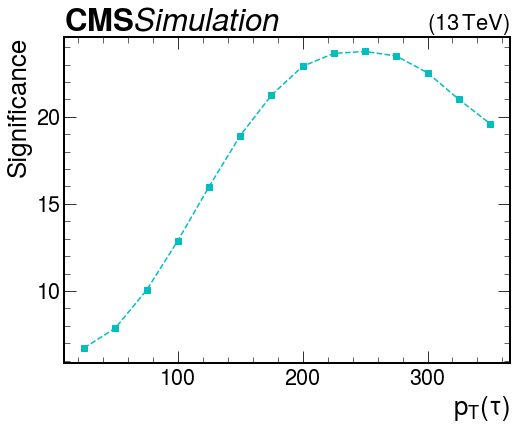

In [20]:
plot_significances(s = Df_s2_cut, 
                   b1 = Df_bgttbar_cut,
                   b2 = Df_bgw_cut,
                   b3 = Df_bgz_cut,
                   var = pt_tau_cut,
                   w = [ex_ev_s[1]] + list(ex_ev_s[3:]),
                   rango = [25, 350, 14], 
                   txt = r'p_T(\tau)');
#plt.xlabel(r'$p_T(\tau)$');

In [21]:
#Applying cuts over the data 
opt = 250
Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=30, del_phi = 0, met = 0)

In [22]:
#Efficiency
print(Df_s2_cut.shape[0]/ Df_s2.shape[0])
print(Df_bgw_cut.shape[0] / Df_bg_wj.shape[0])
print(Df_bgz_cut.shape[0] / Df_bg_zj.shape[0])
print(Df_bgttbar_cut.shape[0] / Df_bg_ttbar.shape[0])

0.34896673017734137
0.027511844469857865
0.05224087867693473
0.007320335326290313


/tmp/ipykernel_1036139/830111472.py:267: RuntimeWarning: invalid value encountered in double_scalars
  sign1 = np.array([var(s, val = i).shape[0] * w[0] \


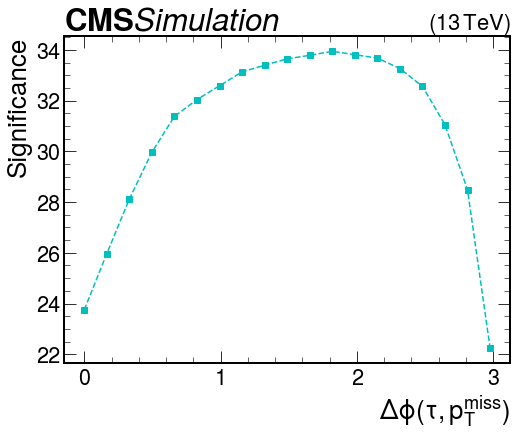

In [23]:
plot_significances(s = Df_s2_cut, 
                   b1 = Df_bgttbar_cut,
                   b2 = Df_bgw_cut,
                   b3 = Df_bgz_cut,
                   var = phi_tau_cut,
                   w = [ex_ev_s[1]] + list(ex_ev_s[3:]),
                   rango = [0, np.pi, 20],
                   txt = r"\Delta\phi(\tau,p_T^{miss})")
#plt.xlabel(r'$\Delta\phi(\tau,p_T^{miss})$');

In [24]:
opt = 250
odp = 2.0

Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=30, del_phi = odp, met = 0)

In [25]:
#Eficiencies
print(Df_s2_cut.shape[0]/ Df_s2.shape[0])
print(Df_bgw_cut.shape[0] / Df_bg_wj.shape[0])
print(Df_bgz_cut.shape[0] / Df_bg_zj.shape[0])
print(Df_bgttbar_cut.shape[0] / Df_bg_ttbar.shape[0])

0.31335189799208557
0.0057180199313837604
0.0123974245676051
0.0023963251040928597


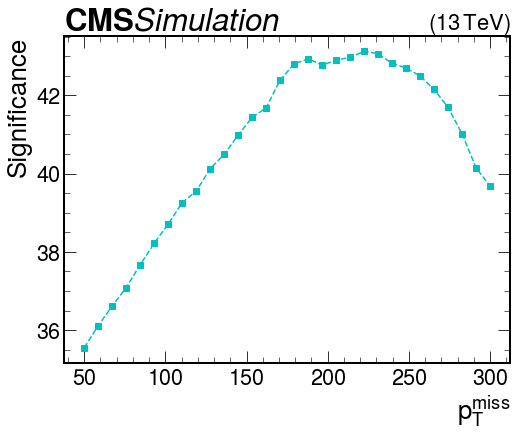

In [26]:
plot_significances(s = Df_s2_cut, 
                   b1 = Df_bgttbar_cut,
                   b2 = Df_bgw_cut,
                   b3 = Df_bgz_cut,
                   var = et_met_cut,
                   w = [ex_ev_s[1]] + list(ex_ev_s[3:]),
                   rango = [50, 300, 30],
                   txt = r"p_T^{miss}")
#plt.xlabel(r'$p_T^{miss}$');

In [27]:
opt = 250
odp = 2.0
omet = 200

Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)

In [28]:
#Eficiencies
print(Df_s2_cut.shape[0]/ Df_s2.shape[0])
print(Df_bgw_cut.shape[0] / Df_bg_wj.shape[0])
print(Df_bgz_cut.shape[0] / Df_bg_zj.shape[0])
print(Df_bgttbar_cut.shape[0] / Df_bg_ttbar.shape[0])

0.27817675509306755
0.0021238359745139684
0.0018684509531624795
0.0004896145976801025


In [29]:
df = pd.DataFrame(ex_ev_s, columns = ["expected_events"])
df['First_Selection'] = np.array([Df_s1.shape[0], Df_s2.shape[0], Df_s3.shape[0],
                                  Df_bg_ttbar.shape[0], Df_bg_wj.shape[0], Df_bg_zj.shape[0]]) * w 
df['Second_Selection'] = np.array([Df_s1.shape[0], Df_s2_cut.shape[0], Df_s3_cut.shape[0], 
                                   Df_bgttbar_cut.shape[0], Df_bgw_cut.shape[0], Df_bgz_cut.shape[0]]) * w 
df

,expected_events,First_Selection,Second_Selection
S600GeV,15.750000,1.015560e+05,101556.000000
S1000GeV,1.350000,9.211050e+03,2562.300000
S1600GeV,0.090000,6.143400e+02,255.330000
Bg_TTbar,5.676667,1.426081e+06,698.230000
Bg_WJ,4.488545,1.373719e+05,291.755399
Bg_ZJ,0.425516,1.685256e+04,31.488181


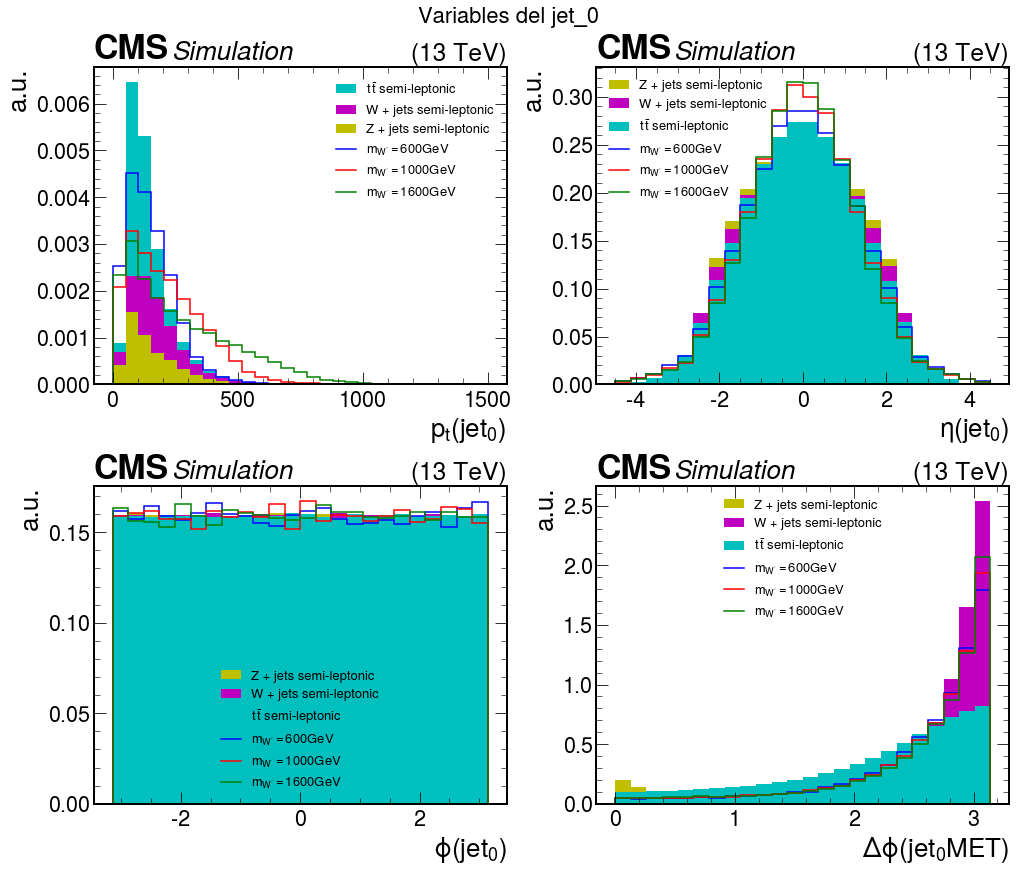

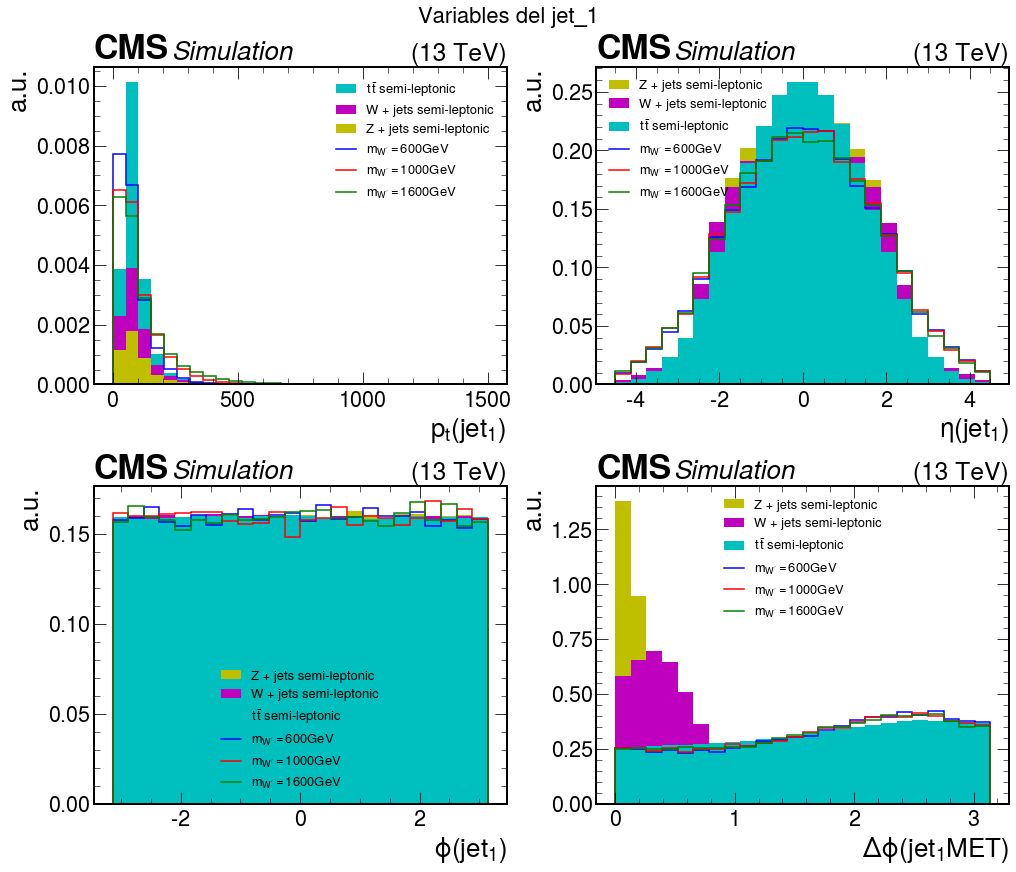

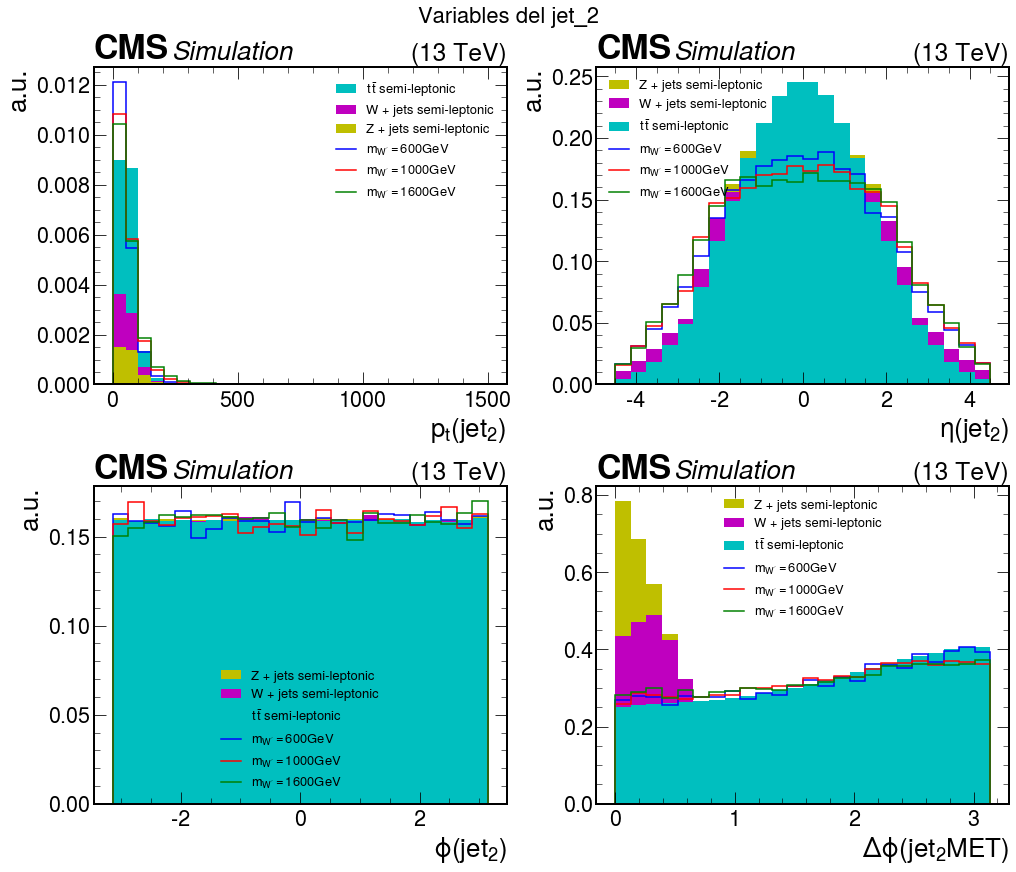

In [30]:
#PT, eta, phi and delta phi with Met for the i = 3 first jets

w2 = df.Second_Selection
w1 = df.First_Selection

for j in range(3):
  plot_pt_eta_phi1(labels = labels, 
                   df1 = df_s1, df2 = df_s2,df3 = df_s3 , size =13, 
                   bg2 = df_bg_wj, bg3 = df_bg_zj, bg1 = df_bg_ttbar, i = j)

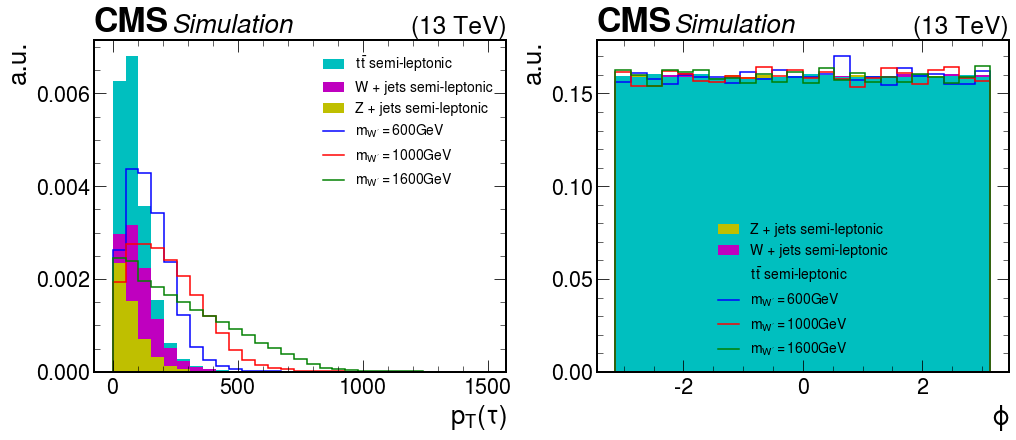

In [32]:
plot_Met_ET_Phi1(df1 =df_s1,df2 =df_s2,df3 =df_s3, size=14,
                 bg2 = df_bg_wj, bg3 = df_bg_zj, bg1 = df_bg_ttbar, labels = labels)

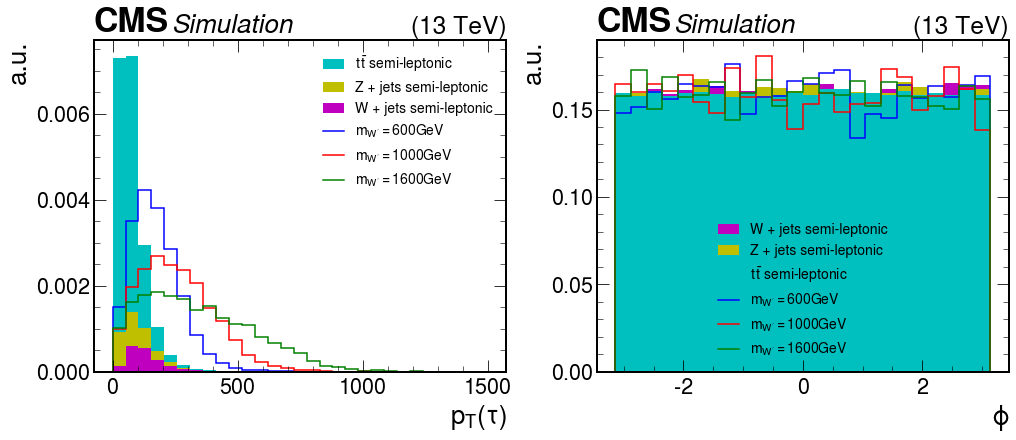

In [33]:
plot_Met_ET_Phi2(df1 = Df_s1, 
                 df2 = Df_s2, 
                 df3 = Df_s3, 
                 bg2 = Df_bg_wj, 
                 bg3 = Df_bg_zj, 
                 bg1 = Df_bg_ttbar,
                 size = 14,
                 labels = labels)

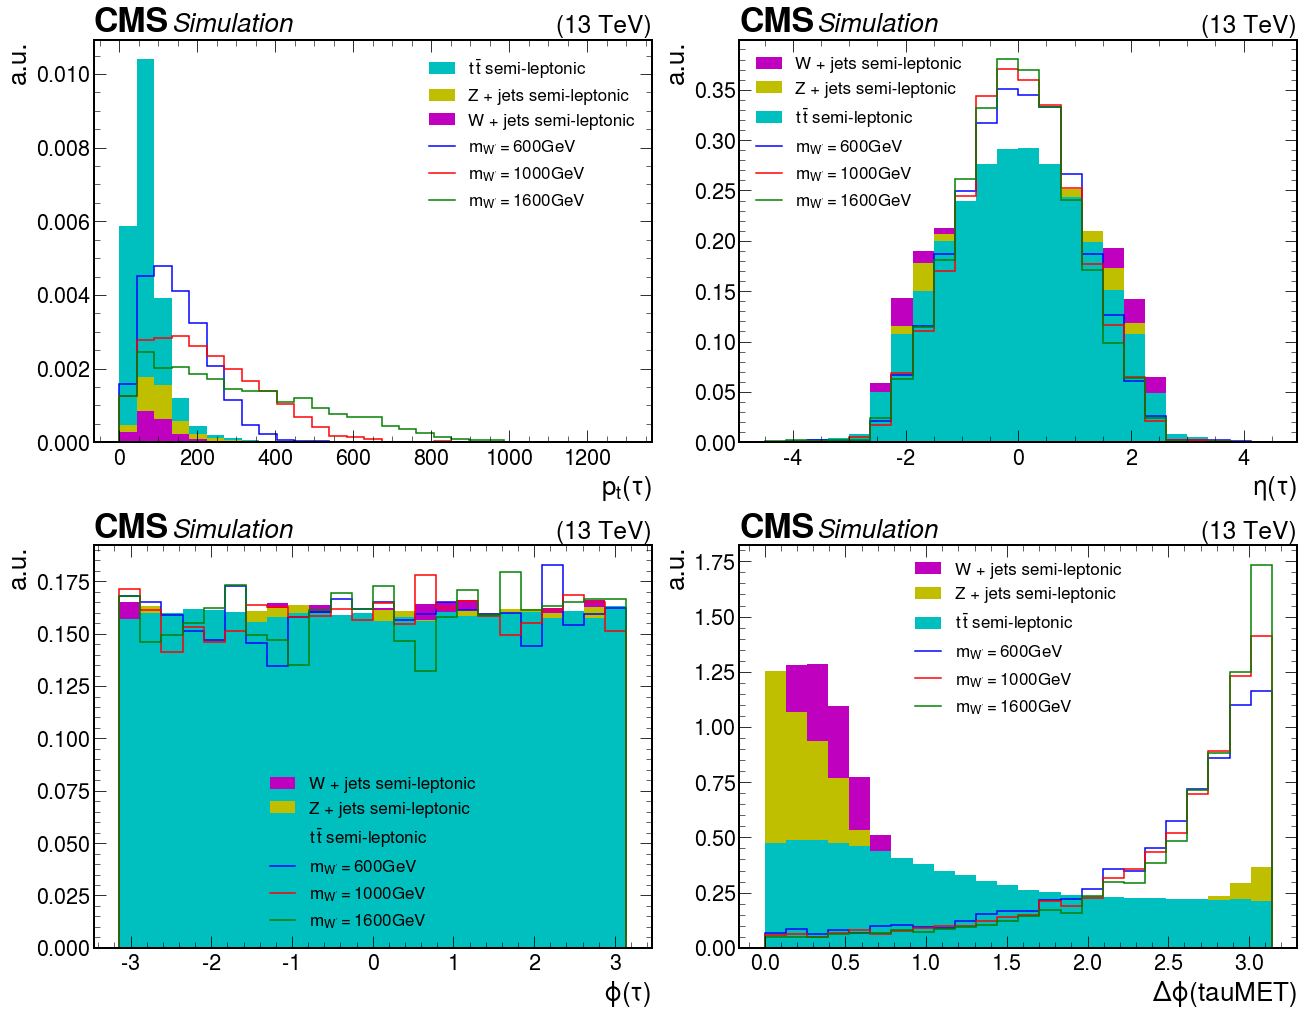

In [35]:
#Pt Eta phi and delta phi with met for the tau
plot_pt_eta_phi2(labels= labels, 
                 obj = "tau", 
                 df1 = Df_s1, 
                 df2 = Df_s2, 
                 df3 = Df_s3,
                 bg2 = Df_bg_wj, 
                 bg3 = Df_bg_zj , 
                 bg1 = Df_bg_ttbar,
                 size = 17)

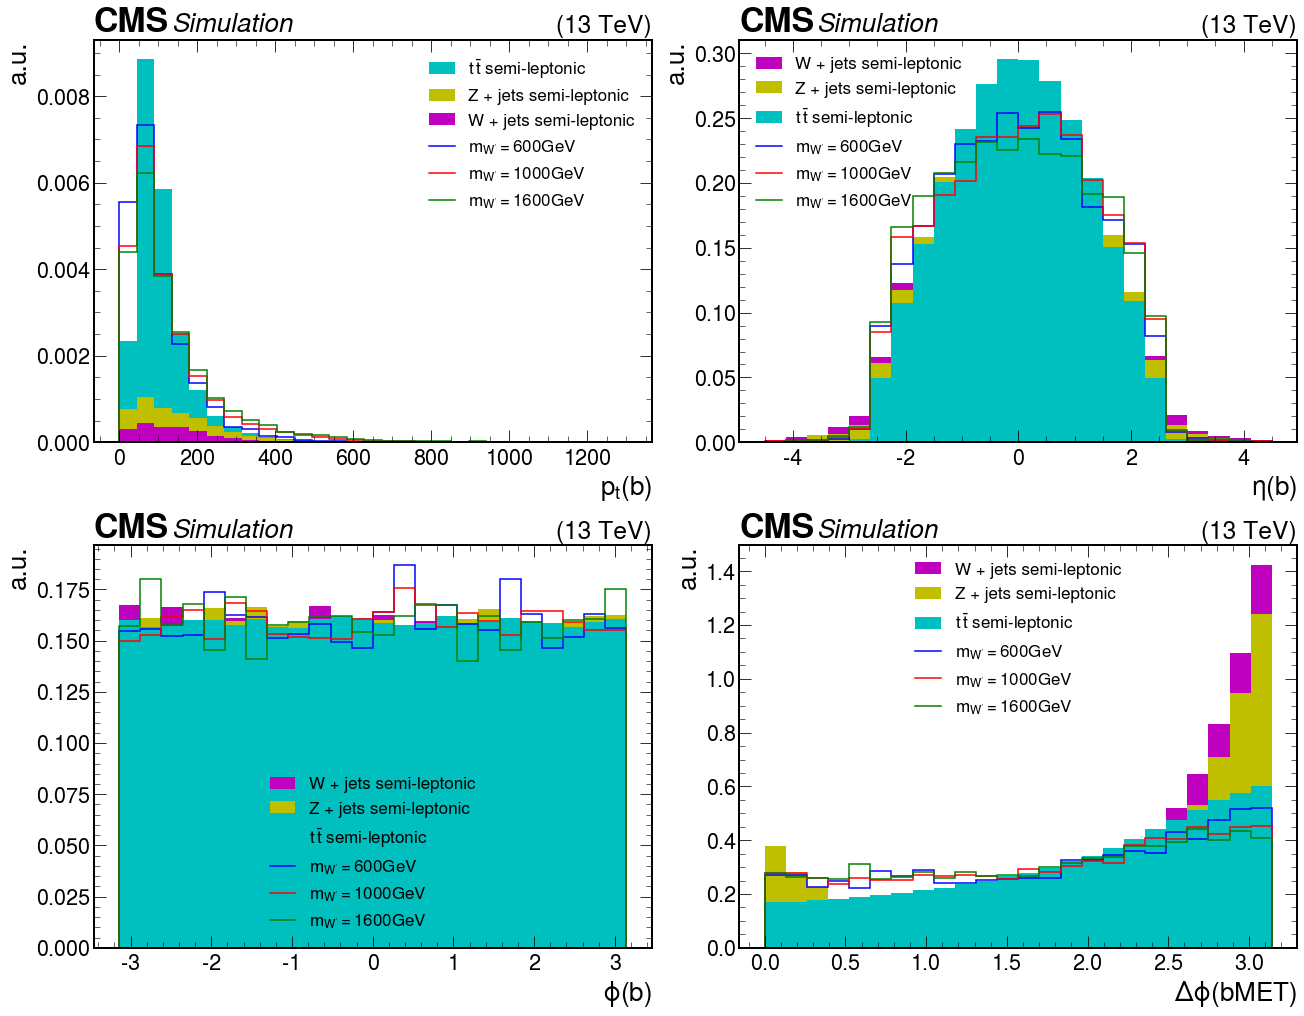

In [36]:
#Pt Eta phi and delta phi with met for the b
plot_pt_eta_phi2(labels= labels,
                 obj = "b", 
                 df1 = Df_s1, 
                 df2 = Df_s2, 
                 df3 = Df_s3,
                 bg2 = Df_bg_wj, 
                 bg3 = Df_bg_zj, 
                 bg1 = Df_bg_ttbar,
                 size = 17)

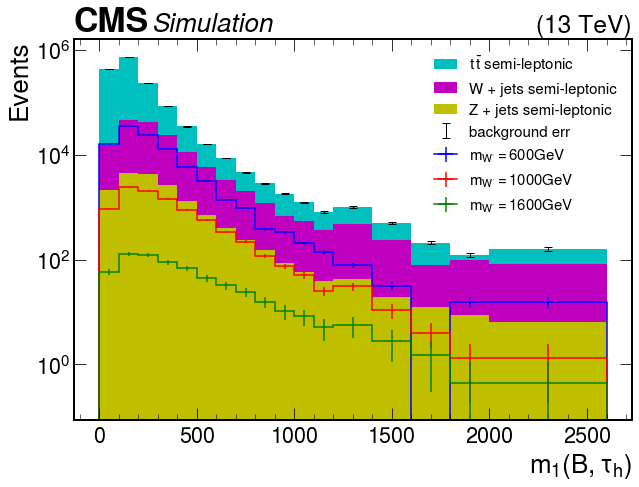

In [40]:
#Invariant Mass between tau, b without cuts
m_tau_b1 = generate_ploteable_invariant_masses(Df_s1,Df_s2, Df_s3)
m_tau_bg = generate_ploteable_invariant_masses(Df_bg_ttbar, Df_bg_wj, Df_bg_zj)
Df_s1['Invariant_mass_tau_b'], Df_s2['Invariant_mass_tau_b'], Df_s3['Invariant_mass_tau_b'] = m_tau_b1
Df_bg_ttbar['Invariant_mass_tau_b'], Df_bg_wj['Invariant_mass_tau_b'], Df_bg_zj['Invariant_mass_tau_b'] = m_tau_bg

plot_mass1(m_type = r'$m_{1}(B,\tau_h)$',
           s1 = Df_s1['Invariant_mass_tau_b'],
           s2 = Df_s2['Invariant_mass_tau_b'],
           s3 = Df_s3['Invariant_mass_tau_b'],
           bg1 = Df_bg_ttbar['Invariant_mass_tau_b'],
           bg2 = Df_bg_wj['Invariant_mass_tau_b'],
           bg3 = Df_bg_zj['Invariant_mass_tau_b'],
           Ws = df.expected_events,
           labels= labels,
           bines = [[i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600]])
            


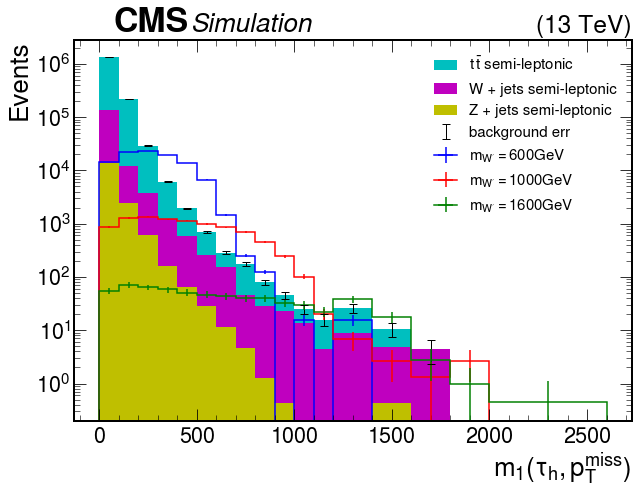

In [41]:
#Transverse mass of tau without cuts
m_trvs_tau_nu1 = generate_ploteable_tr_tau_nu_masses(Df_s1,Df_s2, Df_s3)
m_trvs_tau_nu2 = generate_ploteable_tr_tau_nu_masses(Df_bg_ttbar, Df_bg_wj,Df_bg_zj)
Df_s1['Transverse_mass_tau'], Df_s2['Transverse_mass_tau'], Df_s3['Transverse_mass_tau'] = m_trvs_tau_nu1
Df_bg_ttbar['Transverse_mass_tau'], Df_bg_wj['Transverse_mass_tau'], Df_bg_zj['Transverse_mass_tau'] = m_trvs_tau_nu2

plot_mass1(m_type = r'$m_{1}(\tau_h, p_T^{miss})$',
           s1 = Df_s1['Transverse_mass_tau'],
           s2 = Df_s2['Transverse_mass_tau'],
           s3 = Df_s3['Transverse_mass_tau'],
           bg1 = Df_bg_ttbar['Transverse_mass_tau'],
           bg2 = Df_bg_wj['Transverse_mass_tau'],
           bg3 = Df_bg_zj['Transverse_mass_tau'],
           Ws = df.expected_events,
           labels= labels,
           bines = [[i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600]])


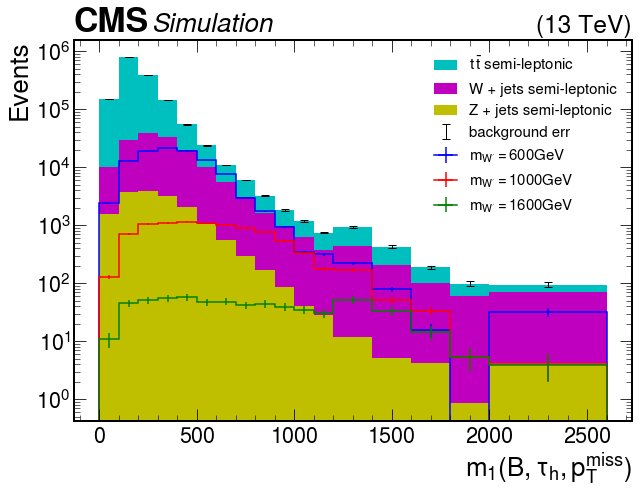

In [42]:
#Total mass between b tau nu without cuts
m_T1 = generate_ploteable_total_masses(Df_s1, Df_s2, Df_s3)
m_Tbg = generate_ploteable_total_masses(Df_bg_ttbar, Df_bg_wj, Df_bg_zj)
Df_s1['Total_mass'], Df_s2['Total_mass'], Df_s3['Total_mass'] = m_T1
Df_bg_ttbar['Total_mass'], Df_bg_wj['Total_mass'], Df_bg_zj['Total_mass'] = m_Tbg


plot_mass1(m_type = r'$m_{1}(B,\tau_h, p_T^{miss})$',
           s1 = Df_s1['Total_mass'],
           s2 = Df_s2['Total_mass'],
           s3 = Df_s3['Total_mass'],
           bg1 = Df_bg_ttbar['Total_mass'],
           bg2 = Df_bg_wj['Total_mass'],
           bg3 = Df_bg_zj['Total_mass'],
           Ws = df.expected_events,
           labels= labels,
           bines = [[i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600],
                   [i for i in range(0,1200,100)] + [i for i in range(1200, 2200,200)]+[2600]])

In [43]:
opt = 250
odp = 2.0
omet = 200

Df_s1_cut = final_cuts(Df_s1, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_s2_cut = final_cuts(Df_s2, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_s3_cut = final_cuts(Df_s3, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_bgw_cut = final_cuts(Df_bg_wj, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_bgz_cut = final_cuts(Df_bg_zj, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)
Df_bgttbar_cut = final_cuts(Df_bg_ttbar, pt_tau = opt, pt_b=30, del_phi = odp, met = omet)

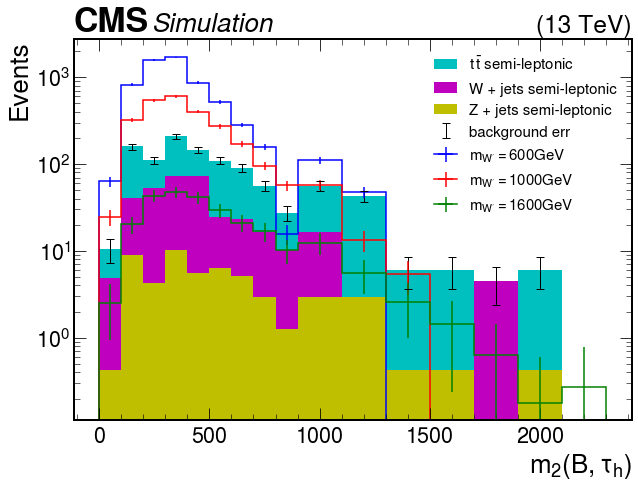

In [44]:
#Invariant Mass between tau, b with cuts

plot_mass1(m_type = r'$m_{2}(B,\tau_h)$',
           s1 = Df_s1_cut['Invariant_mass_tau_b'],
           s2 = Df_s2_cut['Invariant_mass_tau_b'],
           s3 = Df_s3_cut['Invariant_mass_tau_b'],
           bg1 = Df_bgttbar_cut['Invariant_mass_tau_b'],
           bg2 = Df_bgw_cut['Invariant_mass_tau_b'],
           bg3 = Df_bgttbar_cut['Invariant_mass_tau_b'],
           Ws = df.expected_events,
           labels= labels,
           bines = [[i for i in range(0,900,100)] + [i for i in range(900, 2300,200)]+[2300],
                   [i for i in range(0,900,100)] + [i for i in range(900, 2300,200)]+[2300],
                   [i for i in range(0,900,100)] + [i for i in range(900, 2300,200)]+[2300],
                   [i for i in range(0,900,100)] + [i for i in range(900, 2300,200)]+[2300],
                   [i for i in range(0,900,100)] + [i for i in range(900, 2300,200)]+[2300],
                   [i for i in range(0,900,100)] + [i for i in range(900, 2300,200)]+[2300]])


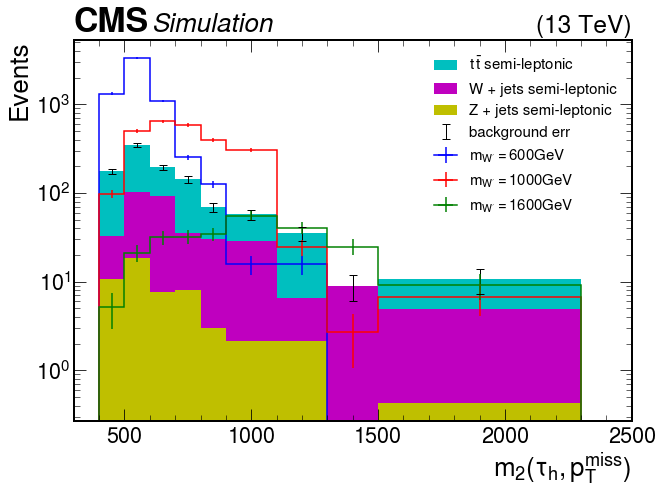

In [45]:
#Transverse mass of tau with cuts
#m_trvs_tau_nu1 = generate_ploteable_tr_tau_nu_masses(Df_600GeV_cut,Df_1000GeV_cut, Df_1600GeV_cut)
#m_trvs_tau_nu2 = generate_ploteable_tr_tau_nu_masses(Df_bgttbar_cut, Df_bgw_cut, Df_bgz_cut)

plot_mass1(m_type = r'$m_{2}(\tau_h, p_T^{miss})$',
           s1 = Df_s1_cut['Transverse_mass_tau'],
           s2 = Df_s2_cut['Transverse_mass_tau'],
           s3 = Df_s3_cut['Transverse_mass_tau'],
           bg1 = Df_bgttbar_cut['Transverse_mass_tau'],
           bg2 = Df_bgw_cut['Transverse_mass_tau'],
           bg3 = Df_bgttbar_cut['Transverse_mass_tau'],
           Ws = df.expected_events,
           labels= labels,
           bines = [[i for i in range(0,900,100)] + [i for i in range(900, 1700,200)]+[2300],
                   [i for i in range(0,900,100)] + [i for i in range(900, 1700,200)]+[2300],
                   [i for i in range(0,900,100)] + [i for i in range(900, 1700,200)]+[2300],
                   [i for i in range(0,900,100)] + [i for i in range(900, 1700,200)]+[2300],
                   [i for i in range(0,900,100)] + [i for i in range(900, 1700,200)]+[2300],
                   [i for i in range(0,900,100)] + [i for i in range(900, 1700,200)]+[2300]])
plt.xlim(300,2500);

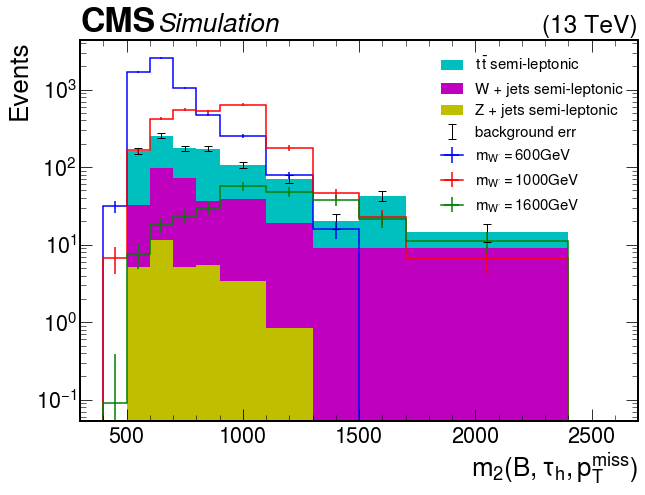

In [46]:
plot_mass1(m_type = r'$m_{2}(B,\tau_h, p_T^{miss})$',
           s1 = Df_s1_cut['Total_mass'],
           s2 = Df_s2_cut['Total_mass'],
           s3 = Df_s3_cut['Total_mass'],
           bg1 = Df_bgttbar_cut['Total_mass'],
           bg2 = Df_bgw_cut['Total_mass'],
           bg3 = Df_bgz_cut['Total_mass'],
           Ws = df.expected_events,
           labels= labels,
           bines = [[i for i in range(0,900,100)] + [i for i in range(900, 1900,200)]+[2400],
                   [i for i in range(0,900,100)] + [i for i in range(900, 1900,200)]+[2400],
                   [i for i in range(0,900,100)] + [i for i in range(900, 1900,200)]+[2400],
                   [i for i in range(0,900,100)] + [i for i in range(900, 1900,200)]+[2400],
                   [i for i in range(0,900,100)] + [i for i in range(900, 1900,200)]+[2400],
                   [i for i in range(0,900,100)] + [i for i in range(900, 1900,200)]+[2400]])
plt.xlim(300,2700);